## Do not run First 3 cells (Only for colab)


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d rajtlakls2510/face-mask-detection

 93% 119M/128M [00:00<00:00, 158MB/s] 
100% 128M/128M [00:00<00:00, 164MB/s]
 93% 119M/128M [00:00<00:00, 158MB/s] 
100% 128M/128M [00:00<00:00, 164MB/s]


In [ ]:
import zipfile
zip = zipfile.ZipFile("/content/face-mask-detection.zip",'r')
zip.extractall("/content")
zip.close()

## Run notebook from here

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Input, Concatenate, GlobalAveragePooling2D, Dropout, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import  MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import os
import pandas as pd
import numpy as np

In [ ]:
train_datagen = ImageDataGenerator(
        zoom_range=0.1,
        rotation_range=25,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest",
)
train_generator = train_datagen.flow_from_directory(
        'face_mask_detector dataset',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 3845 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'with_mask': 0, 'without_mask': 1}

In [ ]:
base_model = MobileNetV2(weights="imagenet", include_top=False,input_shape=(224, 224,3))

inputs = Input(shape=(224, 224, 3))

base_model.trainable=False
x = preprocess_input(inputs)
x = base_model(x, training=False)

headModel = GlobalAveragePooling2D()(x)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
output = Dense(2, activation="softmax")(headModel)


model = Model(inputs=inputs, outputs=output)

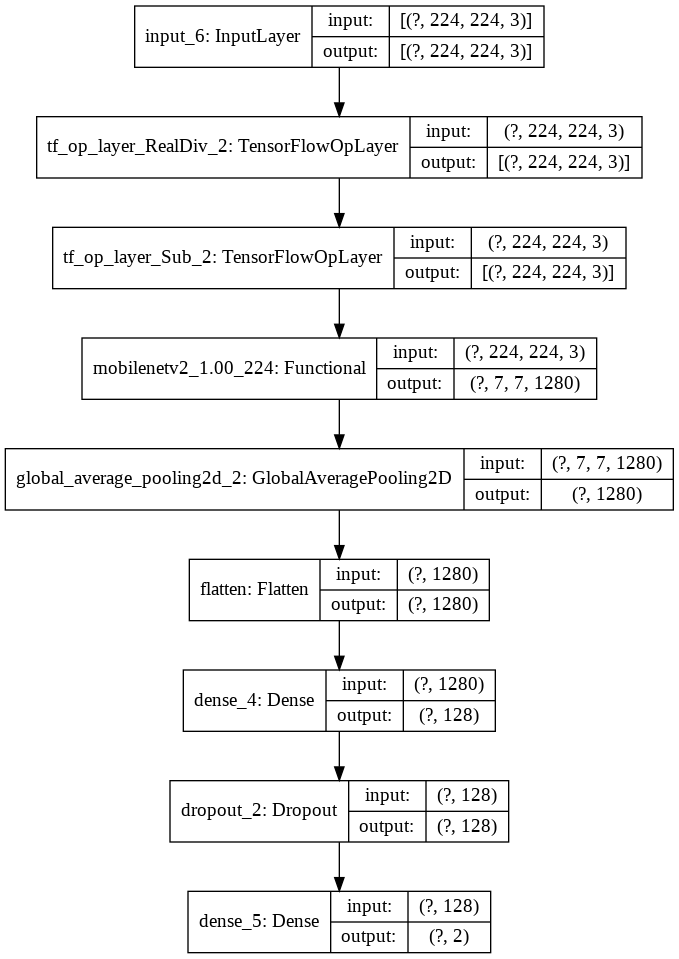

In [ ]:
plot_model(model,show_shapes=True)

In [ ]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_2 (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_2 (TensorFlo [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4, decay= 1e-4/20), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_generator, batch_size=32, epochs=20 )

Epoch 1/20
 40/121 [========>.....................] - ETA: 31s - loss: 0.4063 - accuracy: 0.8125

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


121/121 [==============================] - 48s 398ms/step - loss: 0.2066 - accuracy: 0.9186
Epoch 2/20
121/121 [==============================] - 48s 397ms/step - loss: 0.0704 - accuracy: 0.9779
Epoch 3/20
121/121 [==============================] - 48s 399ms/step - loss: 0.0471 - accuracy: 0.9831
Epoch 4/20
121/121 [==============================] - 49s 408ms/step - loss: 0.0359 - accuracy: 0.9891
Epoch 5/20
121/121 [==============================] - 49s 404ms/step - loss: 0.0358 - accuracy: 0.9873
Epoch 6/20
121/121 [==============================] - 49s 402ms/step - loss: 0.0310 - accuracy: 0.9899
Epoch 7/20
121/121 [==============================] - 48s 400ms/step - loss: 0.0234 - accuracy: 0.9930
Epoch 8/20
121/121 [==============================] - 48s 401ms/step - loss: 0.0241 - accuracy: 0.9909
Epoch 9/20
121/121 [==============================] - 48s 400ms/step - loss: 0.0265 - accuracy: 0.9914
Epoch 10/20
121/121 [==============================] - 49s 401ms/step - loss: 0.0186

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Face Mask Detection/mobilefacenet_99.61.h5')

## Convert Keras model to Tflite model

In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model

In [5]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Face Mask Detection/mobilefacenet_99.61.h5')

In [12]:
tf_lite_convertor = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_convertor.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_convertor.target_spec.supported_types = [tf.float16]
tflite_model = tf_lite_convertor.convert()

INFO:tensorflow:Assets written to: /tmp/tmpvg2w77jr/assets


INFO:tensorflow:Assets written to: /tmp/tmpvg2w77jr/assets


In [13]:
open('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Face Mask Detection/mobilefacenet_99.61_quantized.tflite', 'wb').write(tflite_model)

4807072

In [14]:
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/Colab Notebooks/Deep Learning/Face Mask Detection/mobilefacenet_99.61_quantized.tflite')
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details[0]['shape'],input_details[0]['dtype'],output_details[0]['shape'],output_details[0]['dtype'])

[  1 224 224   3] <class 'numpy.float32'> [1 2] <class 'numpy.float32'>
